In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

## Realized Volatility

Text(0.5, 1.0, 'Realized Volatility of WTI Crude oil')

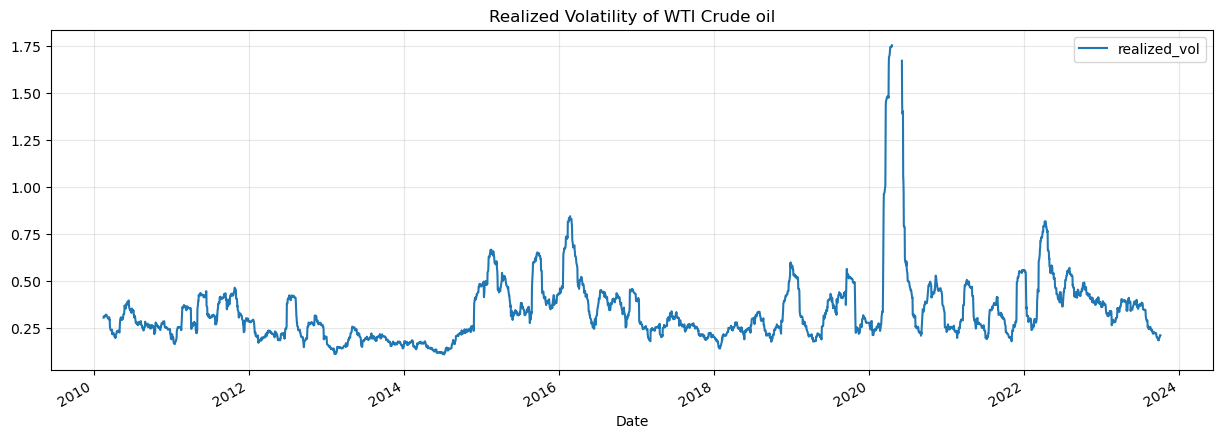

In [25]:
ticker = 'CL=F'

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 10, 4)

tk = yf.Ticker(ticker)

df = pd.DataFrame(
    yf.download(
        ticker, 
        start=start, 
        end=end, 
        progress=False, 
        ignore_tz=True
    )['Adj Close']
)

df['log_ret'] = np.log(df/df.shift(1))

df['realized_vol'] = df['log_ret'].rolling(30).std() * np.sqrt(252)

fig, ax = plt.subplots(figsize=(15, 5))
df.plot(y='realized_vol', figsize=(15, 5), ax=ax)
ax.grid(alpha=0.3)
ax.set_title(f'Realized Volatility of WTI Crude oil')

## NN

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

ret = df['log_ret'].copy()

realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)

returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['Date']

X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

n = 252
split_date = ret.iloc[-n:].index

NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],
            'max_iter': [500, 1000],
            'alpha': [0.00005, 0.0005 ]}
clf = RandomizedSearchCV(NN_vol, para_grid_NN)

clf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf.predict(X.iloc[-n:])

NN_predictions = pd.DataFrame(NN_predictions)
NN_predictions.index = ret.iloc[-n:].index

rmse_NN = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))

print('The RMSE value of NN is {:.6f}'.format(rmse_NN))

plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(NN_predictions / 100, label='Volatility Prediction-NN')
plt.title('Volatility Prediction with Neural Network', fontsize=12)
plt.legend()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [3203, 3207]